# Phosphofructokinase (PFK)
To construct the phosphofructokinase model, first we import __masspy__ and any additional packages that will be necessary.  

In [1]:
import matplotlib.pyplot as plt
import sympy as sym
from scipy import optimize

from cobra import DictList

from mass import MassMetabolite, Simulation, qcqa_model
from mass.enzymes import EnzymeForm, EnzymeModel
from mass.test import create_test_model
from mass.util import  k2Keq, Keq2k, strip_time

Note that the total enzyme concentration of PFK is \\(33 nM = 0.033 \mu M = 0.000033 mM\\).

## Model Construction
The first step of creating the PFK model is to define the EnzymeModel object.

In [2]:
PFK = EnzymeModel("PFK", name="Phosphofructokinase", subsystem="Glycolysis")

## Metabolites
### Ligands
The next step is to define all of the ligands involved in the PFK catalytic mechanism using identifiers and the names found in the BiGG Database (http://bigg.ucsd.edu/). In order to ensure our model is physiologically accurate, it is important to provide the __formula__ keyword with a string representing the chemical formula for each metabolite, and the  __charge__ keyword with an integer representing the metabolite's ionic charge (Note that neutrally charged metabolites are provided with 0). To indicate that the cytosol is the cellular compartment in which the enzymatic reaction occurs, the string "c" is provided to the __compartment__ keyword.

First, the activators, inhibitors, cofactors, and the substrate associated with this enzyme. There are 6 species which must be considered.

In [3]:
f6p_c = MassMetabolite(
    id="f6p_c",
    name="D-Fructose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
fdp_c = MassMetabolite(
    id="fdp_c",
    name="D-Fructose 1,6-bisphosphate",
    formula="C6H10O12P2",
    charge=-4,
    compartment="c")
atp_c = MassMetabolite(
    id="atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
adp_c = MassMetabolite(
    id="adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")
amp_c = MassMetabolite(
    id="amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c")
h_c = MassMetabolite(
    id="h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c") 

After generating the ligands, they are added to the EnzymeModel. The ligands of the EnzymeModel can be viewed using the __EnzymeModel.categorized_ligands__ property. Note that all of the ligands are categorized as undefined. 

In [4]:
PFK.add_metabolites([f6p_c, fdp_c, atp_c, adp_c, amp_c, h_c])
for category, ligands in PFK.categorized_ligands.items():
    print("{0}: {1}".format(category, str([m.id for m in ligands])))

Undefined: ['adp_c', 'amp_c', 'atp_c', 'f6p_c', 'fdp_c', 'h_c']


When metabolites are first added to an EnzymeModel, they are placed in the "Undefined" category. The __EnzymeModel.categorized_ligands__ property can also be used to reassign metabolites to user-defined categories by providing a dictionary where keys are the categories and values are the metabolites. Note that a metabolite can be given placed in more than one category.

In [5]:
PFK.categorized_ligands =  {
    "Substrates": f6p_c,
    "Cofactors": atp_c,
    "Activators": amp_c,
    "Inhibitors": atp_c,
    "Products": [fdp_c, adp_c, h_c]}
for category, ligands in PFK.categorized_ligands.items():
    print("{0}: {1}".format(category, str([m.id for m in ligands])))

Substrates: ['f6p_c']
Cofactors: ['atp_c']
Activators: ['amp_c']
Inhibitors: ['atp_c']
Products: ['adp_c', 'fdp_c', 'h_c']


### Enzyme Forms

This PFK model will be considered a homotetramer with a ordered sequential mechanism and will be based on the (Monod-Wyman-Changeux) MWC model for ligand binding and allosteric regulation. There is also a categorized enzyme form dictionary, accessible via __EnzymeModel.categorized_enzyme_forms__, that behaves similarly to the __EnzymeModel.categorized_ligands__ attribute, as shown below. Alternatively, one can access a __cobra.DictList__ of all EnzymeForms through the __EnzymeModel.enzyme_forms__ attribute.

In [6]:
# Number of identical subunits
n_subunits = 4

for i in range(n_subunits + 1):
    # Make enzyme forms per number of bound activators (Up to 4 Total)
    PFK.make_enzyme_form(
        id="pfk_R{0:d}_c".format(i), 
        name="Automatic", 
        categories="Relaxed", 
        bound_catalytic={},
        bound_effectors={amp_c: i},
        compartment="c");

    PFK.make_enzyme_form(
        id="pfk_R{0:d}_A_c".format(i), 
        name="Automatic", 
        categories="Relaxed", 
        bound_catalytic={atp_c: 1},
        bound_effectors={amp_c: i},
        compartment="c");
    
    PFK.make_enzyme_form(
        id="pfk_R{0:d}_AF_c".format(i), 
        name="Automatic", 
        categories="Relaxed", 
        bound_catalytic={atp_c: 1, f6p_c: 1},
        bound_effectors={amp_c: i},
        compartment="c");

    # Make enzyme forms per number of bound inhibitors (Up to 4 Total)
    PFK.make_enzyme_form(
        id="pfk_T{0:d}_c".format(i), 
        name="Automatic", 
        categories="Tense", 
        bound_catalytic={},
        bound_effectors={atp_c: i},
        compartment="c");
    
# Display newly made EnzymeForms in their categories
for category, enzyme_forms in PFK.categorized_enzyme_forms.items():
    print("{0}: {1}".format(category, str([r.id for r in enzyme_forms])))

Relaxed: ['pfk_R0_AF_c', 'pfk_R0_A_c', 'pfk_R0_c', 'pfk_R1_AF_c', 'pfk_R1_A_c', 'pfk_R1_c', 'pfk_R2_AF_c', 'pfk_R2_A_c', 'pfk_R2_c', 'pfk_R3_AF_c', 'pfk_R3_A_c', 'pfk_R3_c', 'pfk_R4_AF_c', 'pfk_R4_A_c', 'pfk_R4_c']
Tense: ['pfk_T0_c', 'pfk_T1_c', 'pfk_T2_c', 'pfk_T3_c', 'pfk_T4_c']


#### Optional: Define compartment

Because the character "c" represents the cytosol compartment, it is recommended to define and set the compartment in the __EnzymeModel.compartments__ attribute.

In [7]:
PFK.compartments = {"c": "Cytosol"}
print(PFK.compartments)

{'c': 'Cytosol'}


## Reactions
### Enzyme Reactions
Once all of the MassMetabolite and EnzymeForm objects have been created for each of the species in PFK, the next step is to define all of the reactions that occur in its mechanism. The __EnzymeModel.make_enzyme_reaction__ method can be used to create an enzyme binding reaction, a reaction represnting a transition between states, etc. It requires the same parameters needed to initialize a MassReaction, and it allows for one to define a category for the reaction, similar to how ligands can be categorized and accessible through the __EnzymeModel.enzyme_reactions__ property. Additionally, metabolites and EnzymeForms can also be directly added to the reaction by providing the __add_metabolites__ kwarg a dictionary, where keys can be EnzymeForm and MassMetabolites objects or their ids if they already exist in the EnzymeModel, and values are the stoichiometric coefficients (reactants have negative coefficients, products have positive ones). Note that after the creation of each MassReaction object, the reaction is added to the EnzymeModel.

In this model of PFK, there are 24 reactions occuring.

In [8]:
for i in range(n_subunits + 1):
    # Make reactions for enzyme-ligand binding and catalytzation per number of bound activators (Up to 4 Total)
    PFK.make_enzyme_reaction(
        id="PFK_R{0:d}1".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="atp_c binding",
        metabolites_to_add={
            "pfk_R{0:d}_c".format(i): -1, 
            "atp_c": -1, 
            "pfk_R{0:d}_A_c".format(i): 1})
    
    PFK.make_enzyme_reaction(
        id="PFK_R{0:d}2".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="f6p_c binding",
        metabolites_to_add={
            "pfk_R{0:d}_A_c".format(i): -1, 
            "f6p_c": -1, 
            "pfk_R{0:d}_AF_c".format(i): 1})
    
    PFK.make_enzyme_reaction(
        id="PFK_R{0:d}3".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=False,
        categories="catalyzation",
        metabolites_to_add={
            "pfk_R{0:d}_AF_c".format(i): -1, 
            "pfk_R{0:d}_c".format(i): 1, 
            "adp_c": 1, 
            "fdp_c": 1,
            "h_c": 1})
    
    if i < n_subunits:
        # Make enzyme reactions for enzyme-activator binding
        PFK.make_enzyme_reaction(
            id="PFK_R{0:d}0".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="amp_c activation",
            metabolites_to_add={
                "pfk_R{0:d}_c".format(i): -1, 
                "amp_c": -1, 
                "pfk_R{0:d}_c".format(i + 1): 1})

        # Make enzyme reactions for enzyme-inhibitor binding
        PFK.make_enzyme_reaction(
            id="PFK_T{0:d}".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="atp_c inhibition",
            metabolites_to_add={
                "pfk_T{0:d}_c".format(i): -1, 
                "atp_c": -1, 
                "pfk_T{0:d}_c".format(i + 1): 1})
# Make reaction representing enzyme transition from R to T state
PFK.make_enzyme_reaction(
    id="PFK_L",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="R/T transition",
    metabolites_to_add={
        "pfk_R0_c": -1, 
        "pfk_T0_c": 1})

# Display newly made reactions in their categories
for category, enzyme_reactions in PFK.categorized_enzyme_reactions.items():
    print("{0}: {1}".format(category, str([r.id for r in enzyme_reactions])))

atp_c binding: ['PFK_R01', 'PFK_R11', 'PFK_R21', 'PFK_R31', 'PFK_R41']
f6p_c binding: ['PFK_R02', 'PFK_R12', 'PFK_R22', 'PFK_R32', 'PFK_R42']
catalyzation: ['PFK_R03', 'PFK_R13', 'PFK_R23', 'PFK_R33', 'PFK_R43']
amp_c activation: ['PFK_R10', 'PFK_R20', 'PFK_R30', 'PFK_R40']
atp_c inhibition: ['PFK_T1', 'PFK_T2', 'PFK_T3', 'PFK_T4']
R/T transition: ['PFK_L']


### Create and  Unify Rate Parameters
The next step is to unify rate parameters of binding steps that are not unique. Therefore, custom rate laws are used to reduce the number of parameters that need to be defined and better represent the model.

The rate laws can be unified using the __EnzymeModel.unify_rate_parameters__ method. This method requires a list of reactions whose rate laws that should be identical, along with a string representation of the new identifier to use on the unified parameters. There is also the optional kwarg argument __prefix__, which if set to True, prefixes the new parameter identifier with the enzyme model identifier. This can be used to help prevent custom parameters from being replaced when multiple models are merged. 

#### Allosteric Transitions: Symmetry Model

Once rate parameters are unified, the allosteric regulation of this enzyme must be accounted for. Because this model is to be based on the (Monod-Wyman-Changeux) MWC model for ligand binding and allosteric regulation, the rate laws of the allosteric binding reactions must be adjusted to reflect the symmetry in the model using the number of identical binding sites to help determine the scalars for the parameters. 

For this model, PFK is considered a homotetramer, meaning it has four identical subunits \\(\nu = 4\\). Each subunit can be allosterically activated by AMP or inhibited by ATP. The helper functions __k2Keq__ and __Keq2k__ will be used to help facilitate the rate law changes in this example so that the final rate laws are dependent on the forward rate (kf) and equilibrium (Keq) constants.

In [9]:
enzyme_prefix = True
abbreviations = ["F", "A", "I", "ACT"]
ligands = [f6p_c, atp_c, atp_c, amp_c]

for met, unified_id in zip(ligands, abbreviations):
    category = {"F": "binding",
                "A": "binding",
                "I": "inhibition",
                "ACT": "activation"}[unified_id]
    reactions = PFK.categorized_enzyme_reactions[" ".join((met.id, category))]
    PFK.unify_rate_parameters(reactions, unified_id, rate_type=2, enzyme_prefix=enzyme_prefix)
    # Add the coefficients to make symmetry model rate laws for activation and inhibition 
    if unified_id in ["I", "ACT"]:
        for i, reaction in enumerate(reactions):
            custom_rate = str(strip_time((reaction.rate)))
            custom_rate = custom_rate.replace("kf_", "{0:d}*kf_".format(n_subunits - i))
            custom_rate = custom_rate.replace("kr_", "{0:d}*kr_".format(i + 1))
            PFK.add_custom_rate(reaction, custom_rate)

PFK.unify_rate_parameters(PFK.categorized_enzyme_reactions["catalyzation"], "PFK")
# Update rate laws to be in terms of kf and Keq
PFK.custom_rates.update(k2Keq(PFK.custom_rates))


# Display newly made reactions in their categories
for category, enzyme_reactions in PFK.categorized_enzyme_reactions.items():
    header = "Category: " + category
    print(header + "\n" + "-"*len(header))
    for reaction in enzyme_reactions:
        print(reaction.id + ": " + str(reaction.rate))
    print()

Category: atp_c binding
-----------------------
PFK_R01: kf_PFK_A*(atp_c(t)*pfk_R0_c(t) - pfk_R0_A_c(t)/Keq_PFK_A)
PFK_R11: kf_PFK_A*(atp_c(t)*pfk_R1_c(t) - pfk_R1_A_c(t)/Keq_PFK_A)
PFK_R21: kf_PFK_A*(atp_c(t)*pfk_R2_c(t) - pfk_R2_A_c(t)/Keq_PFK_A)
PFK_R31: kf_PFK_A*(atp_c(t)*pfk_R3_c(t) - pfk_R3_A_c(t)/Keq_PFK_A)
PFK_R41: kf_PFK_A*(atp_c(t)*pfk_R4_c(t) - pfk_R4_A_c(t)/Keq_PFK_A)

Category: f6p_c binding
-----------------------
PFK_R02: kf_PFK_F*(f6p_c(t)*pfk_R0_A_c(t) - pfk_R0_AF_c(t)/Keq_PFK_F)
PFK_R12: kf_PFK_F*(f6p_c(t)*pfk_R1_A_c(t) - pfk_R1_AF_c(t)/Keq_PFK_F)
PFK_R22: kf_PFK_F*(f6p_c(t)*pfk_R2_A_c(t) - pfk_R2_AF_c(t)/Keq_PFK_F)
PFK_R32: kf_PFK_F*(f6p_c(t)*pfk_R3_A_c(t) - pfk_R3_AF_c(t)/Keq_PFK_F)
PFK_R42: kf_PFK_F*(f6p_c(t)*pfk_R4_A_c(t) - pfk_R4_AF_c(t)/Keq_PFK_F)

Category: catalyzation
----------------------
PFK_R03: kf_PFK*pfk_R0_AF_c(t)
PFK_R13: kf_PFK*pfk_R1_AF_c(t)
PFK_R23: kf_PFK*pfk_R2_AF_c(t)
PFK_R33: kf_PFK*pfk_R3_AF_c(t)
PFK_R43: kf_PFK*pfk_R4_AF_c(t)

Category: amp_c

## The Steady State
### Solve steady state concentrations symbolically
To determine the steady state of the enzyme, first we will remove the ligands from the rate equations by substituting them for a value of 1 to account for the forward rate consants including the steady state concentrations of their corresponding ligands. Next, we will identify the enzyme forms and store them in a list. Finally, we define a dictionary of the ordinary differential equations as sympy expressions with the ligand concentrations lumped into the rate constants.

In [10]:
ode_dict = {
    sym.Symbol(enzyme_form.id): sym.Eq(strip_time(enzyme_form.ode))
    for enzyme_form in PFK.enzyme_forms}

We also use the catalyzation reactions in order to create our equation for \\(v_{\mathrm{PFK}}\\).

In [11]:
PFK.make_enzyme_net_flux_equation(PFK.categorized_enzyme_reactions["catalyzation"], 
                                  use_rates=True, update_enzyme=True)
sym.pprint(PFK.enzyme_net_flux_equation)

v_PFK = kf_PFK⋅(pfk_R0_AF_c(t) + pfk_R1_AF_c(t) + pfk_R2_AF_c(t) + pfk_R3_AF_c
(t) + pfk_R4_AF_c(t))


We then identify equations for the unknown concentrations we wish to solve for in each reaction. We will treat the completely free form of the enzyme with no bound species as our dependent variable.

In [12]:
# Get enzyme forms
enzyme_forms = PFK.enzyme_forms.copy()
# Reverse list for performance
enzyme_forms.reverse()

enzyme_solutions = {}
for enzyme_form in enzyme_forms:
    # Skip dependent variable
    if "pfk_R0_c" == str(enzyme_form):
        continue
    else:
        enzyme_form = sym.Symbol(enzyme_form.id)
    # Solve for the enzyme form and update the solution dictionary
    sol = list(sym.solveset(ode_dict[enzyme_form].subs(enzyme_solutions), enzyme_form))
    enzyme_solutions[enzyme_form] = sol.pop()
    enzyme_solutions.update({enzyme_form: sol.subs(enzyme_solutions) 
                             for enzyme_form, sol in enzyme_solutions.items()})

The reaction rate equation can be utilized as the last necessary equation in order to solve for the our final unknown concentration variable in terms of the rate and equilibrium constants. Once the unknown variable has been solved for, we substitute the solution back into our other equations. Because __sym.solveset__ expects the input equations to be equal to 0, we can use the __EnzymeModel.enzyme_net_flux_error__ method to get the appropriate expression.

In [13]:
# Solve for enzyme form
sym.pprint(strip_time(PFK.enzyme_net_flux_error()))
sol = sym.solveset(strip_time(PFK.enzyme_net_flux_error()).subs(enzyme_solutions), "pfk_R0_c")
# Add to solution dictionary
enzyme_solutions[sym.Symbol("pfk_R0_c")] = list(sol).copy().pop()
# Update solutions with free variable solutions
enzyme_solutions = {enzyme_form: sym.simplify(solution.subs(enzyme_solutions))
                    for enzyme_form, solution in enzyme_solutions.items()}

-kf_PFK⋅(pfk_R0_AF_c + pfk_R1_AF_c + pfk_R2_AF_c + pfk_R3_AF_c + pfk_R4_AF_c) 
+ v_PFK


#### Numerical Values
At this point, numerical values are defined for the dissociation constants and the concentrations of the substrates, cofactors, activators, and inhibitors. Providing these numerical values will speed up the subsequent calculations. 

To do this, experimental data is used to define the dissociations constants for the different binding steps under the QEA assumption. The concentrations of the non-enzyme species are taken from the glycolysis model. 

Experimental data gives the following for the dissociation constants: 

$$\\K_i=0.1 mM,\ K_a=0.033 mM,\ K_A=0.068 mM, K_F=0.1 mM,\ $$ and an allosteric constant of \\(K_L = 0.0011\\).

__Note:__ The \\(K_i\\) binding constant for ATP as an inhibitor was increased by a factor of ten since magnesium complexing of ATP is not considered here. 

In [14]:
numerical_values = {}

# Get ligand IDs
ligand_ids = sorted([str(ligand) for ligand in PFK.ligands])
parameter_ids = ["_".join((PFK.id, abbrev)) if enzyme_prefix else abbrev for abbrev in abbreviations + ["L"]]

# Load the glycolysis model to extract steady state values
glycolysis = create_test_model("glycolysis")

# Get the steady state flux value and add to numerical values
PFK.enzyme_net_flux = glycolysis.reactions.get_by_id(PFK.id).steady_state_flux
numerical_values.update({PFK.enzyme_flux_symbol: PFK.enzyme_net_flux})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): glycolysis.initial_conditions[glycolysis.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}
numerical_values.update(initial_conditions)

# Define parameter values and add to numerical values
parameter_values = {
    "Keq_" + parameter_id: value 
    for parameter_id, value in zip(parameter_ids, [1/0.1, 1/0.068, 1/0.1, 1/0.033, 0.0011])}
numerical_values.update(parameter_values)

# Substitute values into equations
enzyme_solutions = {enzyme_form: sym.simplify(solution.subs(numerical_values))
                    for enzyme_form, solution in enzyme_solutions.items()}

# Display numerical values
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))

v_PFK = 1.12
adp_c = 0.29
amp_c = 0.0867281
atp_c = 1.6
f6p_c = 0.0198
fdp_c = 0.0146
h_c = 8.99757e-05
Keq_PFK_F = 10.0
Keq_PFK_A = 14.705882352941176
Keq_PFK_I = 10.0
Keq_PFK_ACT = 30.3030303030303
Keq_PFK_L = 0.0011


The last part of this step is to simplify the solutions for the enzyme forms and, as a QCQA, ensure that only rate constants are the only symbolic arguments in the solutions. 

In [15]:
args = tuple(sorted(set([
    str(arg) for sol in enzyme_solutions.values() 
    for arg in list(sol.atoms(sym.Symbol))])))
print(args)

('kf_PFK', 'kf_PFK_A', 'kf_PFK_F')


### Determine rate constants
#### Total Enzyme Concentration and $r_{T}$ 
After solving for the enzyme forms, the next step is to define equations for the total enzyme concentration and for the fraction of the enzyme in the T state to be used as constraints for determining the rate parameters. To view the equation for the total enzyme concentration, we can use the __EnzymeModel.total_enzyme_equation__ property.

In [16]:
sym.pprint(PFK.enzyme_concentration_total_equation)

PFK_Total = pfk_R0_AF_c(t) + pfk_R0_A_c(t) + pfk_R0_c(t) + pfk_R1_AF_c(t) + pf
k_R1_A_c(t) + pfk_R1_c(t) + pfk_R2_AF_c(t) + pfk_R2_A_c(t) + pfk_R2_c(t) + pfk
_R3_AF_c(t) + pfk_R3_A_c(t) + pfk_R3_c(t) + pfk_R4_AF_c(t) + pfk_R4_A_c(t) + p
fk_R4_c(t) + pfk_T0_c(t) + pfk_T1_c(t) + pfk_T2_c(t) + pfk_T3_c(t) + pfk_T4_c(
t)


The total concentration of PFK is 0.000033 mM. The __EnzymeModel.total_enzyme_concentration__ atrribute can be used to set and store this concentration.

In [17]:
PFK.enzyme_concentration_total = 33e-6
print(PFK.enzyme_concentration_total)

3.3e-05


To determine the rate constants, we can set up an optimization problem where we minimize the error between the measured and calculated total enzyme concentrations. We start by creating the objective function based on the absolute error between the measured and calculated total enzyme concentrations. We can use the __EnzymeModel.enzyme_concentration_total_error__ method to get the symbolic expression for the constraint. 

In [18]:
enzyme_total_constraint = abs(strip_time(PFK.enzyme_concentration_total_error()))
sym.pprint(enzyme_total_constraint)

│-PFK_Total + pfk_R0_AF_c + pfk_R0_A_c + pfk_R0_c + pfk_R1_AF_c + pfk_R1_A_c +
 pfk_R1_c + pfk_R2_AF_c + pfk_R2_A_c + pfk_R2_c + pfk_R3_AF_c + pfk_R3_A_c + p
fk_R3_c + pfk_R4_AF_c + pfk_R4_A_c + pfk_R4_c + pfk_T0_c + pfk_T1_c + pfk_T2_c
 + pfk_T3_c + pfk_T4_c│


We introduce our solutions for the enzyme forms to get an equation for the error in the enzyme total concentration in terms of the rate constants.

In [19]:
enzyme_total_constraint = sym.simplify(enzyme_total_constraint.subs(
    enzyme_solutions).subs({PFK.enzyme_total_symbol: PFK.enzyme_concentration_total}))
sym.pprint(enzyme_total_constraint)
obj_func = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

│          60.2443780219149   1.07115712991052   7.14443780219149│
│-3.3e-5 + ──────────────── + ──────────────── + ────────────────│
│              kf_PFK_F           kf_PFK_A            kf_PFK     │


Another constraint can be set on the amount of inhibited enzyme in the steady state of the system using the T fraction (denoted as \\(r_{T}\\)). This fraction is simply the amount of inhibited enzyme over the total amount of enzyme. Assume 15-25% of PFK is in inhibited form for this constraint. 

To make the fraction expression, we can use the __EnzymeModel.make_enzyme_fraction__ method. This method is designed to assist in making fractions and ratios by providing a string identifying the categorized dict attribute (either "forms" for the __EnzymeModel.categorized_enzyme_forms__ or "reactions" for the __EnzymeModel.enzyme_reactions__), two strings identifying the categories from the attribute to sum and use in the numerator and the denominator, and a bool indicating whether to substitute numerical values into the expression to return a float or to keep the ratio as a sympy expression.

__Note:__ "Equation" can be passed to either the numerator or the denominator to utilize the formula for the corresponding equation attrubute(i.e.  __EnzymeModel.enzyme_concentration_total_equation__ for "forms" or  __EnzymeModel.enzyme_net_flux_equation__ for "reactions").

In [20]:
lb_t_fraction, ub_t_fraction = (0.15, 0.25)

r_T_expr = PFK.make_enzyme_fraction("forms", top="Tense", bottom="Equation")
r_T_expr = sym.simplify(strip_time(r_T_expr).subs(enzyme_solutions))

r_T_lb_constraint_func = lambda x: sym.lambdify(args, r_T_expr - lb_t_fraction)(*x)
r_T_ub_constraint_func = lambda x: sym.lambdify(args, ub_t_fraction - r_T_expr)(*x)

Lastly, we place lower and upper bounds on the rate constants to ensure that the values are non-negative and are within physiological limits, and then we solve the optmization problem. Once the optimization has finished, we check whether it was successful, and if so, what the optimality and errors are associated with this particular solution instance.

In [21]:
print("Ordered Args: {0}\n".format(str(args)))

bounds = ((1e3, 1e9), (1e3, 1e9), (1e3, 1e9))
cons = ({"type": "ineq", "fun": r_T_ub_constraint_func},
        {"type": "ineq", "fun": r_T_lb_constraint_func})

sol = optimize.minimize(
    obj_func, [2e6, 6e4, 5e6], method="trust-constr", bounds=bounds, constraints=cons,
    options={"gtol": 1e-12, "xtol": 1e-12, "maxiter": 1e4, "disp": True})

parameter_values.update(dict(zip(args, [round(x) for x in sol.x])))

print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    print("Otimization Optimality: {0:.4e}".format(sol.optimality))
    print("Optimization Error: {0:.4e}".format(enzyme_total_constraint.subs(parameter_values)))
    print("Parameter Solutions: {:}".format(str({arg: parameter_values[arg] for arg in args})))
    print("Enzyme T-fraction: {:.4f}".format(r_T_expr.subs(parameter_values)))

Ordered Args: ('kf_PFK', 'kf_PFK_A', 'kf_PFK_F')



/miniconda3/envs/masspy-dev/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.


`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 288, CG iterations: 82, optimality: 1.05e-10, constraint violation: 0.00e+00, execution time: 1.1e+01 s.

Optimization Success: True
Otimization Optimality: 1.0476e-10
Optimization Error: 4.7283e-11
Parameter Solutions: {'kf_PFK': 2000064.0, 'kf_PFK_A': 61635.0, 'kf_PFK_F': 5000028.0}
Enzyme T-fraction: 0.1921


With a successful optimization, the model is updated with the parameter values.  The inhibition and activation reactions are set to have a high forward rate constant and the allosteric transition even higher, limiting the amount of unbound enzyme and ensuring the R-T transition dynamics are determined only by its allosteric constant. 

__Note:__ This assumption for the rate constants can be made because none of the enzyme concentrations are dependendent on the activation, inhibition, and allosteric rate constants.

In [22]:
# Add the activation, inhibition, and allosteric rate constants
for abbrev, value in zip(["I", "ACT", "L"], [1e6, 1e6, 1e6**2]):
    to_join = ("kf", PFK.id, abbrev) if enzyme_prefix else ("kf", abbrev)
    param = "_".join(to_join)
    parameter_values.update({param: value})
# Display numerical values
for k, v in parameter_values.items():
    print("{0} = {1}".format(k, v))

Keq_PFK_F = 10.0
Keq_PFK_A = 14.705882352941176
Keq_PFK_I = 10.0
Keq_PFK_ACT = 30.3030303030303
Keq_PFK_L = 0.0011
kf_PFK = 2000064.0
kf_PFK_A = 61635.0
kf_PFK_F = 5000028.0
kf_PFK_I = 1000000.0
kf_PFK_ACT = 1000000.0
kf_PFK_L = 1000000000000.0


### Solve steady state concentrations numerically

Once the rate constants have been defined, the steady state concentrations of the enzyme can be determined.

In [23]:
# Substitute values into equations
initial_conditions.update({
    str(enzyme_form): round(float(sym.simplify(solution.subs(parameter_values))), 12)
    for enzyme_form, solution in enzyme_solutions.items()})

for header, dictlist in zip(["Ligand", "\nEnzyme"], [PFK.ligands, PFK.enzyme_forms]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for species in dictlist:
        ic = initial_conditions[species.id]
        print("{0} = {1}".format(species.id, ic))

Ligand Concentrations
---------------------
f6p_c = 0.0198
fdp_c = 0.0146
atp_c = 1.6
adp_c = 0.29
amp_c = 0.0867281
h_c = 8.99757e-05

Enzyme Concentrations
----------------------
pfk_R0_c = 6.9014e-08
pfk_R0_A_c = 8.1613e-08
pfk_R0_AF_c = 3.232e-09
pfk_T0_c = 7.6e-11
pfk_R1_c = 7.25509e-07
pfk_R1_A_c = 8.57957e-07
pfk_R1_AF_c = 3.3974e-08
pfk_T1_c = 4.859e-09
pfk_R2_c = 2.86009e-06
pfk_R2_A_c = 3.382225e-06
pfk_R2_AF_c = 1.33933e-07
pfk_T2_c = 1.16606e-07
pfk_R3_c = 5.011115e-06
pfk_R3_A_c = 5.925939e-06
pfk_R3_AF_c = 2.34662e-07
pfk_T3_c = 1.243797e-06
pfk_R4_c = 3.292458e-06
pfk_R4_A_c = 3.893526e-06
pfk_R4_AF_c = 1.5418e-07
pfk_T4_c = 4.975186e-06


#### Set Initial Conditions and Parameters
Once the steady state concentrations have been determined, the initial conditions and parameters are added to the model.

In [24]:
# Set initial conditions
for met, concentration in initial_conditions.items():
    PFK.metabolites.get_by_id(str(met)).ic = concentration
PFK.set_initial_conditions()

# Add the custom parameters and values for kf and Keq to model
PFK.custom_parameters.update(parameter_values)
# PYK_L uses standard reaction parameters and not custom parameters
PFK_L = PFK.enzyme_reactions.PFK_L
PFK_L.kf = PFK.custom_parameters.pop(PFK_L.kf_str)
PFK_L.Keq = PFK.custom_parameters[PFK_L.Keq_str]

#### Optional: Ordering of internal species and reactions
Sometimes, it is also desirable to reorder the metabolite and reaction objects inside the model to follow the physiology. To reorder the internal species, one can use the method __cobra.DictList.get_by_any__ method with the list of metabolite identifiers in the desirable order. To ensure all metabolites are still present and not forgotten in the model, a QC/QA check is also performed. 

In [25]:
new_metabolite_order = ['f6p_c', 'fdp_c', 'amp_c', 'adp_c', 'atp_c', 'h_c',
                        'pfk_R0_c', 'pfk_R0_A_c', 'pfk_R0_AF_c', 
                        'pfk_R1_c', 'pfk_R1_A_c', 'pfk_R1_AF_c', 
                        'pfk_R2_c', 'pfk_R2_A_c', 'pfk_R2_AF_c', 
                        'pfk_R3_c', 'pfk_R3_A_c', 'pfk_R3_AF_c',
                        'pfk_R4_c', 'pfk_R4_A_c', 'pfk_R4_AF_c',  
                        'pfk_T0_c','pfk_T1_c', 'pfk_T2_c', 'pfk_T3_c', 'pfk_T4_c']

if len(PFK.metabolites) == len(new_metabolite_order):
    PFK.metabolites = DictList(PFK.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = ["PFK_R01", 'PFK_R02', "PFK_R03", "PFK_R10", 
                      "PFK_R11", "PFK_R12", "PFK_R13", "PFK_R20", 
                      "PFK_R21", "PFK_R22", "PFK_R23", "PFK_R30", 
                      "PFK_R31", "PFK_R32", "PFK_R33", "PFK_R40", 
                      "PFK_R41", "PFK_R42", "PFK_R43", "PFK_L", 
                      "PFK_T1", "PFK_T2", "PFK_T3", "PFK_T4"]

if len(PFK.reactions) == len(new_reaction_order):
    PFK.reactions = DictList(PFK.reactions.get_by_any(new_reaction_order))
    
PFK.update_S(matrix_type="DataFrame");

## model Validation 
### QC/QA model
Before saving the model, it is important to ensure that the model is elementally balanced, and that the model can be integrated into a larger network for simulation. Therefore, the __qcqa_model__ method is used to provide a report on the model quality and indicate whether simulation is possible and if not, what parameters and/or initial conditions are missing.

In [26]:
qcqa_model(PFK, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒═══════════════════════════════╕
│ MODEL ID: PFK                 │
│ SIMULATABLE: True;            │
│ NUMERICAL CONSISTENCY: True   │
╞═══════════════════════════════╡
╘═══════════════════════════════╛


### Constraint Satisfaction and Error Values
Another QC/QA check we perform is to substitute the steady state numerical values back into the constraints used in determining the rate constants in order to ensure that the constraints remain satisified, and that errors are small. 

In [27]:
t_fraction = PFK.make_enzyme_fraction("forms", top="Tense", bottom="Equation", use_values=True)
print("Enzyme T-fraction: {:.4f}".format(t_fraction))
print("Constraints Satisfied: {0}\n".format(
    lb_t_fraction <= t_fraction and t_fraction <= ub_t_fraction))

print("Concentration Absolute Error: {0:.4e}".format(abs(PFK.enzyme_concentration_total_error(use_values=True))))
print("Flux Absolute Error: {0:.4e}".format(abs(PFK.enzyme_net_flux_error(use_values=True))))

Enzyme T-fraction: 0.1921
Constraints Satisfied: True

Concentration Absolute Error: 4.9000e-11
Flux Absolute Error: 2.1612e-06


### Add Enzyme to MassModel
In order to determine whether the model can be successfully integrated into a model, another model can be loaded, merged with the model, and simulated. To validate this model, it will be merged with a __glycolysis__ model. 

To integrate the EnzymeModel into the MassModel, we first remove the reaction that the EnzymeModel will be replacing. Afterwards, we can use the __MassModel.merge__ method to add the EnzymeModel. When merging an EnzymeModel and a MassModel, the EnzymeModel should always be merged into the MassModel.

In [28]:
# Load and merge glycolysis and hemoglobin models
glycolysis = create_test_model("glycolysis")
# Remove the PFK MassReaction, then merge the EnzymeModel into the MassModel
glycolysis.remove_reactions(glycolysis.reactions.get_by_id("PFK"))
glycolysis_PFK = glycolysis.merge(PFK)
glycolysis_PFK

Name,Glycolysis_PFK
Memory address,0x0127356048
Stoichiometric Matrix,40x45
Matrix Rank,38
Matrix Type,"dense, float64"
Number of Metabolites,40
Number of Reactions,45
Number of Initial Conditions,40
Number of Forward Rate Constants,22
Number of Equilibrium Constants,27
Number of Irreversible Reactions,10


Using __MassModel.merge(EnzymeModel)__ enables the EnzymeModel and MassModel to be merged like regular MassModel objects. However, all attributes specific to the EnzymeModel (e.g categorized attributes) are condensed into a speciailzed container called an __EnzymeDict__. The EnzymeDict is a special in that its contents can be accessed as if they were attributes. These attributes can be viewed using __EnzymeDict.keys()__.
All __EnzymeDicts__ can be accessed via __MassModel.enzymes__.


In [29]:
print(str(glycolysis_PFK.enzymes) + "\n")
print("Attribute Accessors: " + "; ".join(list(
    glycolysis_PFK.enzymes.PFK.keys())) + "\n")
glycolysis_PFK.enzymes.PFK

[<EnzymeDict PFK at 0x125058488>]

Attribute Accessors: id; name; subsystem; ligands; enzyme_forms; enzyme_reactions; categorized_ligands; categorized_enzyme_forms; categorized_enzyme_reactions; enzyme_concentration_total; enzyme_concentration_total_equation; enzyme_net_flux; enzyme_net_flux_equation; S; model; description



Name,PFK
Memory address,0x0125058488
Stoichiometric Matrix,26x24
Matrix Rank,20
Subsystem,Glycolysis
Number of Ligands,6
Number of EnzymeForms,20
Number of Enzyme Reactions,24
Total Enzyme Concentration,3.3e-05
Enzyme Net Flux,1.12


### Validate Steady State
To find the steady state of the model, the __Simulation.find_steady_state_model__ method can used. 
To validate the steady state of the model, concentration and flux solutions can be plotted using the __plot_simulation__ function.

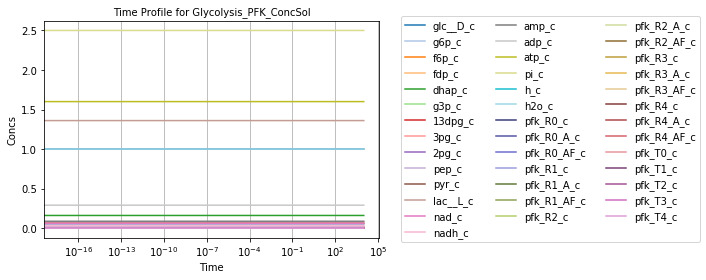

In [30]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(glycolysis_PFK)
options={'method': 'LSODA', 'atol': 1e-15}
sim.find_steady_state_model(model=glycolysis_PFK, strategy="simulate",
                            update_initial_conditions=True, 
                            update_reactions=True, **options)

t0, tf = (0, 1e4)
conc_sol, flux_sol = sim.simulate_model(glycolysis_PFK, time=(t0, tf), **options)
conc_sol.preview_time_profile

## Export
After validation, the model is ready to be saved. The model can either be exported as a ".json" file or if the model conforms to SBML standards, as a ".xml" file using the classes in __mass.io__. To export the model, only the path to the directory and the name of the model need to be specified. Both are shown. 

In [31]:
from mass.io import json#, sbml

### Export using JSON

In [32]:
json.save_json_model(filename="../models/json_models/PFK.json", model=PFK)

### Export using SBML

In [33]:
# sbml.write_sbml_model(filename="../models/json_models/PFK.json", model=PFK)